## Simulated random walk polymerization with PySIMM using CGenFF

### Prerequisites

To run this tutorial a few additional python packages should set up in your system
 
 - **PySIMM** for managing molecules and forcefield typing: <br/>(https://github.com/polysimtools/pysimm). 
 - For PySIMM to work properly it should be **integrated with LAMMPS** 
 (the integration only includes the setup of envirnomental variable `$LAMMPS_EXEC` that points towards LAMMPS binary).
 - Optional: **NGLView** for in-code molecule visualization <br/>
 (https://github.com/nglviewer/nglview).

In [1]:
from pysimm import lmps
from pysimm import system
from pysimm import forcefield
from pysimm.apps.random_walk import random_walk, random_walk_tacticity, check_tacticity

import matplotlib.pyplot as mplp
import matplotlib.image as mplim
from IPython import display
import numpy 
import sys
import os

### Additional API:

##### **Function to cap a polymer**

Here is a description of a PySIMM method that can cap a polymer chain with methyls (*-CH<sub>3</sub>*). The method requires a PySIMM system as an input, that represents an uncapped polymer.
Here are the main assertions of the method:
  * Assumes that the system atoms are typed with **CGenFF** forcefield (pysimm.forcefield.charmm).
  * Requires the atoms to be capped have their linker attribute set to either _'head'_ or _'tail'_.
  * Assumes that atoms to be capped are carbons and they are in  **sp3 hybridization**.  
  
The method does 3 things:
  1. Adds a methyl carbon to a valence position of the linker carbon that should be capped.
  2. Adds 3 hydrogens at the approximate vacant positions of the tetrahedron. 
  3. Runs a short conjugated gradient minimization to put all atoms to their minimal energy positions.

In [2]:
def cap_with_methyls(input_sst, ff):
    '''
        Utility method that implements capping of the free ends of polymer chains with methyl 
        groups in all-atom forcefield representation
    '''
    # Let's cap the oligomer with the methyl (-CH3) group
    captypes = []
    for cpn in ['CG331', 'HGA3']:
        tmp = input_sst.particle_types.get(cpn)
        if tmp:
            cpt = tmp[0]
        else:
            cpt = ff.particle_types.get(cpn)[0].copy()
            input_sst.particle_types.add(cpt)
        captypes.append(cpt)

    for p in input_sst.particles:
        if p.linker is not None:
            if len(p.bonded_to) < 4:

                # assuming that the linker atom is sp3 hybridized C, let's define the last non-occupied direction
                # of the tetrahedron
                dir = numpy.zeros(3)
                for p_ in p.bonded_to:
                    dir += numpy.array([p.x, p.y, p.z]) - numpy.array([p_.x, p_.y, p_.z])

                dir = dir / numpy.linalg.norm(dir)
                cap_c = system.Particle(x=p.x + 1.53 * dir[0], y=p.y + 1.53 * dir[1], z=p.z + 1.53 * dir[2],
                                        type=captypes[0])
                input_sst.add_particle_bonded_to(cap_c, p, f=ff)

                dir_h = numpy.array([1.0, 1.0, 1.0])
                dir_h[0] = -(dir_h[1] * dir[1] + dir_h[2] * dir[2]) / dir[0]
                dir_h = dir_h / numpy.linalg.norm(dir_h)

                dir_h2 = numpy.array([1.0, 1.0, -1.0])
                dir_h2[1] = (dir[2] / dir[0] - dir_h[2] / dir_h[0]) / (dir[1] / dir[0] - dir_h[1] / dir_h[0])
                dir_h2[0] = dir[2] / dir[0] - dir[1] * dir_h2[1] / dir[0]
                dir_h2 = dir_h2 / numpy.linalg.norm(dir_h2)

                stretch = 0.78
                input_sst.add_particle_bonded_to(system.Particle(x=cap_c.x + stretch * dir[0] + stretch * dir_h[0],
                                                                 y=cap_c.y + stretch * dir[1] + stretch * dir_h[1],
                                                                 z=cap_c.z + stretch * dir[2] + stretch * dir_h[2],
                                                                 type=captypes[1]), cap_c, f=ff)
                input_sst.add_particle_bonded_to(system.Particle(x=cap_c.x + stretch * dir[0] + stretch * dir_h2[0],
                                                                 y=cap_c.y + stretch * dir[1] + stretch * dir_h2[1],
                                                                 z=cap_c.z + stretch * dir[2] + stretch * dir_h2[2],
                                                                 type=captypes[1]), cap_c, f=ff)
                input_sst.add_particle_bonded_to(system.Particle(x=cap_c.x + stretch * dir[0] - stretch * dir_h2[0],
                                                                 y=cap_c.y + stretch * dir[1] - stretch * dir_h2[1],
                                                                 z=cap_c.z + stretch * dir[2] - stretch * dir_h2[2],
                                                                 type=captypes[1]), cap_c, f=ff)
    input_sst.objectify()
    input_sst.center(what='particles', at=[0.0, 0.0, 0.0], move_both=False)

    sim = lmps.Simulation(input_sst, log='capping_opt.log')
    sim.add_min(min_style='cg', name='min_cg', etol=1.0e-6, ftol=1.0e-6, maxiter=int(1e+6), maxeval=int(1e+7))
    sim.run()

##### **Functions to draw results**

Method that plots ratio of meso/racemo diads in the system as calculated by the `pysimm.apps.random_walk.check_tacticity()`

In [5]:
def display_diad_distrib(data, canvas):
    canvas.hist(list(map(int, data)), bins=[-0.5, 0.5, 1.5], rwidth=0.2, 
                range=(-0.5, 1.5), density=False);
    mplp.xticks(ticks=[0, 1], labels=['Racemo', 'Meso'], fontsize=16)
    canvas.set_ylabel('Number of diads', fontsize=18)
    canvas.set_xlabel('Diad type', fontsize=18)
    return canvas

Method draws a PySIMM molecular system by creating a temporary .PDB file and using means of NGLView to show it on the notebook canvas. 

If the `fname` file name is set will also save the temporary .pdb file under that name.

In [6]:
try:
    import nglview
except ImportError as err:
    print('No NGL|View module installed for this Python kernell')

def display_system(sstm, fname=None, labels_on=False):
    is_temp = False
    if not fname:
        fname = 'tmp_file.pdb'
        is_temp = True

    sstm.write_pdb(fname)
    
    if 'nglview' in sys.modules.keys():
        view = nglview.show_structure_file(fname)
        if labels_on:
            view.add_label(color='black', scale=1.3, labelType='text', 
                           labelText = [str(pt.tag) for pt in sstm.particles], 
                           zOffset=2.0, attachment='middle_center')
    if is_temp:
        os.remove(fname)

    return view

### Step **I**:  Preparing the repetitive unit

Let's load the repetitive unit of the polymer to the `pysimm.system()` from a `.pdb` file that has `'CONNECT'` section (PySIMM interprets that section and makes bonds between the atoms of the system accordingly).

The `system.read_pdb` method supports additional string parameter that points to the `.str` (CHARMM stream) file which can be used to update charges of the particles of the system. 

Additionally, using the **nglview** Python package we can visualize its structure directly from the same '.mol2' file.

In [7]:
data_path = '../../../../pysimm/models/monomers/topologies/'

sst = system.read_pdb(data_path + 'cbma.pdb', str_file=data_path + 'cbma.str')
sst.set_charge()
print('Total charge of the rep. unit is {}q'.format(round(sst.charge, 6)))

display_system(sst, labels_on=True)

(debug) PySIMM: reading file
(debug) PySIMM: read_pdb: reading file '../../../../pysimm/models/monomers/topologies/cbma.str'
Total charge of the rep. unit is 0.0q


NGLWidget()

Here is an example of definition of head and tail atoms in the CBMA repetitive unit. 


As shown above, the undercoordinated carbon atoms (carbons with incomplete valency) have the <font color="#1cb9c7">indices 1 and 2</font>. They will be the <font color="#1cb9c7">head</font> (the atom with which the current repeating unit connects to the previous repeating unit) and the <font color="#1cb9c7">tail</font> (the atom to which the next repeating unit connects to) during the pysimm polymerization process

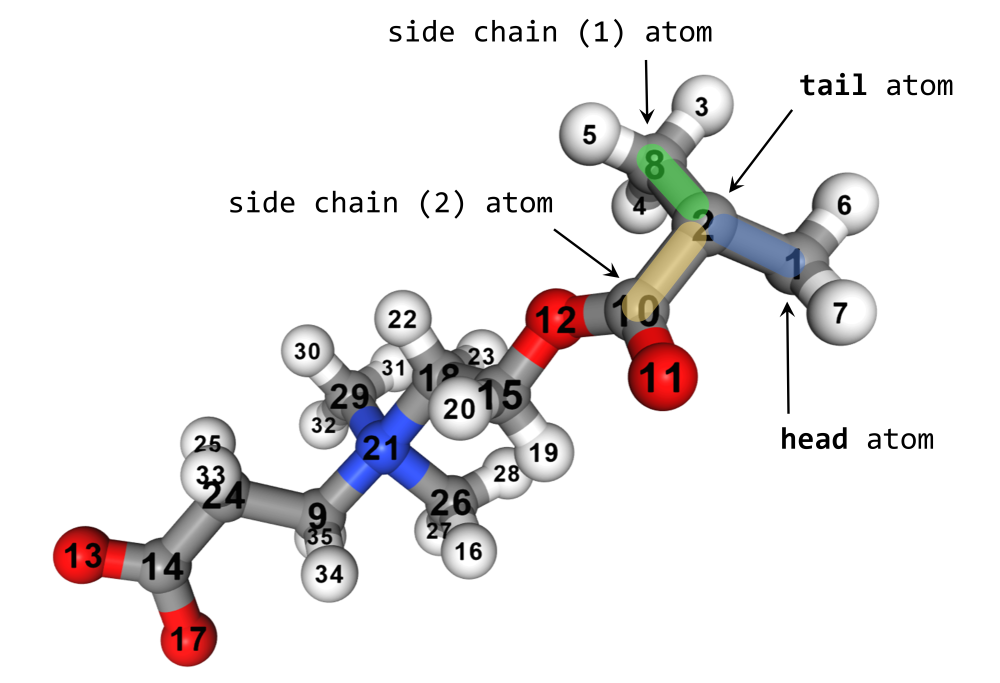

In [8]:
display.Image('../figures/figure2.png', embed=True, retina=True)

In [9]:
lnkr_atoms = {'head': 1, 'tail': 2}

for itm, nm in lnkr_atoms.items():
    sst.particles[nm].linker = itm

Let's type the repetitive unit with basic pysimm <font color="#1cb9c7">CGenFF</font> automatic typing tool. 

The partial charges of all particles were read from the .str file, so there is no need to reassign them (in principle PySIMM can do it using Gasteiger method)

In [10]:
ff = forcefield.Charmm()
sst.apply_forcefield(ff, charges=None)

PySIMM: Dihedrals assigned successfully. 
IMPORTANT: all dihedral weighting factors (coefficients to compensate for double counting in rings) are currently set to 1.0.
If those values are different for your system please multiply corresponding force constants by the weights manually.



### Step **II**: Making the polymer and checking its tacticity

Once the forcefield types and charges are defined, one can use the forcefield-assisted random walk method. Let's built a short (15 rep. units) chain.

In [12]:
sngl_chain = random_walk(sst, 15, 
                         forcefield=ff, density=0.01,
                         print_to_screen='false', traj=False, unwrap=True)

PySIMM: Molecule 1 inserted
11:43:48: 1/15 monomers added
11:43:48: 2/15 monomers added
11:43:48: starting relax_002 LAMMPS simulation
11:43:49: relax_002 simulation using LAMMPS successful
11:43:49: 3/15 monomers added
11:43:49: starting relax_003 LAMMPS simulation
11:43:50: relax_003 simulation using LAMMPS successful
11:43:50: 4/15 monomers added
11:43:50: starting relax_004 LAMMPS simulation
11:43:52: relax_004 simulation using LAMMPS successful
11:43:52: 5/15 monomers added
11:43:52: starting relax_005 LAMMPS simulation
11:43:54: relax_005 simulation using LAMMPS successful
11:43:54: 6/15 monomers added
11:43:54: starting relax_006 LAMMPS simulation
11:43:56: relax_006 simulation using LAMMPS successful
11:43:56: 7/15 monomers added
11:43:56: starting relax_007 LAMMPS simulation
11:43:59: relax_007 simulation using LAMMPS successful
11:43:59: 8/15 monomers added
11:43:59: starting relax_008 LAMMPS simulation
11:44:03: relax_008 simulation using LAMMPS successful
11:44:03: 9/15 mon

Once the built is sucsessesfull, let's visualise the oligomer chain we built.

In [13]:
display_system(sngl_chain, fname='oligomer.15unts.uncapped.vacuum.pdb')

NGLWidget()

So far, the oligomer chain is <font color="#1cb9c7">uncapped</font>. There are two backbone atoms in the system that are undercoordinated. Let's use the method that is set in appendix to <font color="#1cb9c7">connect methyl groups</font> to those undercoordinated atoms.

In [14]:
oligomer = sngl_chain.copy()
cap_with_methyls(oligomer, ff)
oligomer.center(what='particles', at=[0.0, 0.0, 0.0], move_both=False)

11:45:21: starting LAMMPS simulation
11:45:23: simulation using LAMMPS successful


In [15]:
display_system(oligomer, 'oligomer.15unts.capped.vacuum.pdb')

NGLWidget()

Finally, let's check the tacticity of the created oligomer. 

The `check_tacticity()` method of the `random_walk` application analyzes the local geometry of atoms for polymers which can have tacticity. The method returns the distribution of meso/racemo diads along the backbone of the macromolecule (see the image). 

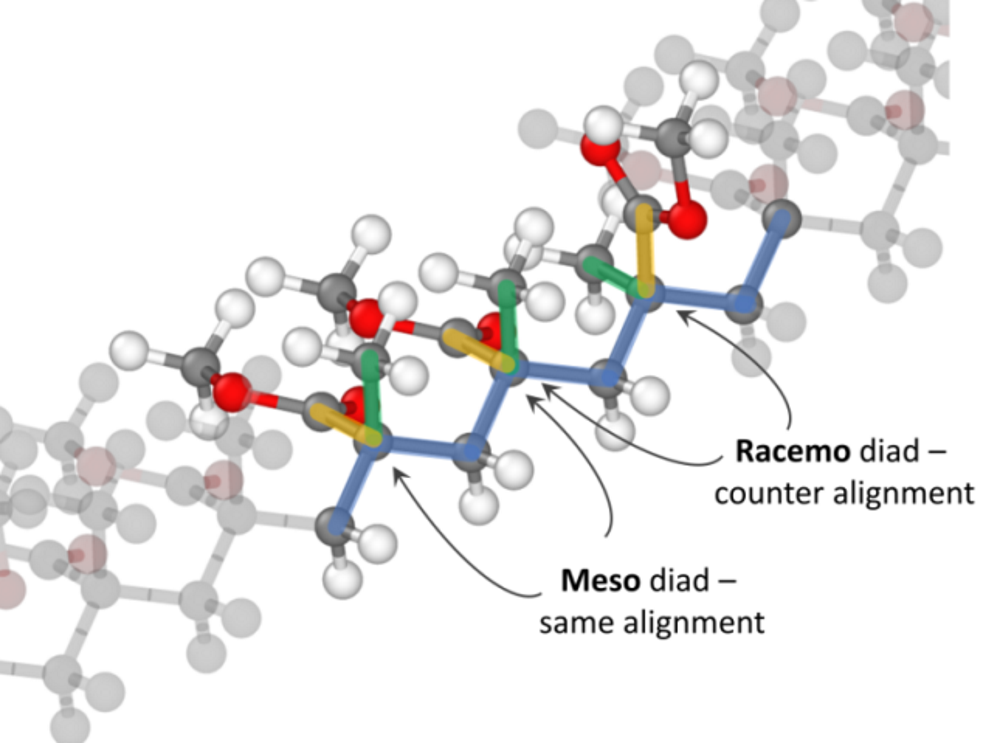

In [16]:
display.Image('../figures/figure3.png', embed=True, retina=True)

 The input parameters of the method are: 
  - A pysimm system that represents a macromolecule to analyze.
  - A list with 4 integers that defines the indices of the node atoms in a repetitive unit of the macromolecule. Indices in that order represent: <font color='blue'>**(1)**</font> first atom of the backbone; <font color='blue'>**(2)**</font> second atom  of the backbone; <font color='green'>**(3)**</font> the first atom of the first side chain (or methyl, or hydrogen); <font color='orange'>**(4)**</font> the first atom of the second side chain. <br/><ins>Note</ins>: the colors of the atom indices match the colors of the vectors on the figure below.
  - Length of the repetitive unit of the macromolecule


The second variable of `check_tacticity()` output is the list that shows whether the two consecutive repetitive units in the chain form either a meso (True) or a racemo (False) diad. 

Let's examine obtained oligomer and print the result in the form of simple 2-column histogram that will show the ratio of meso to racemo diads. 

Indices for the analyzed repetitive unit are highlighted on the **first image** of the tutorial, and they are 1, 2, 8, and 10.

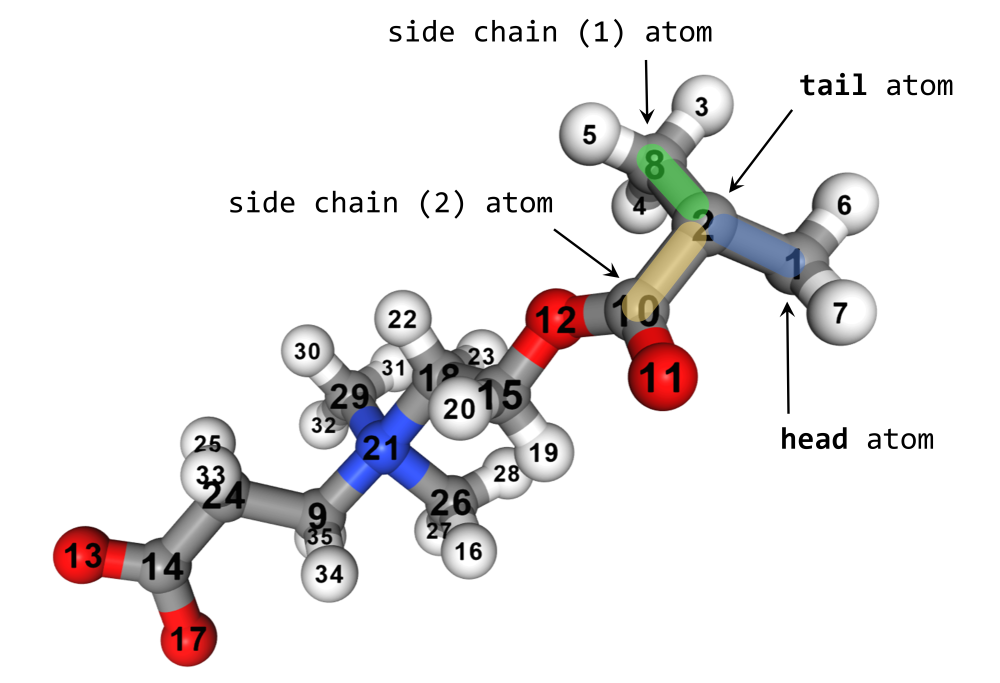

In [17]:
display.Image('../figures/figure2.png', embed=True, retina=True)

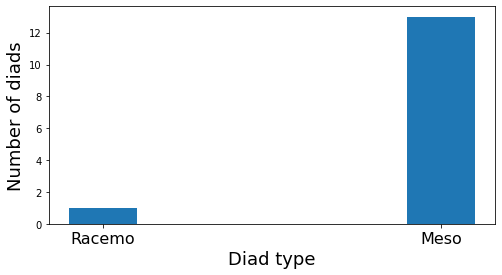

In [18]:
tacticity_stat = check_tacticity(sngl_chain, [1, 2, 8, 10], len(sst.particles))

fig, ax = mplp.subplots(1, 1, figsize=(8, 4))
display_diad_distrib(tacticity_stat[1], ax);

In this particular case, among 15 monomers (thus 14 diads) we see that most of them have a meso- configuration, meaning that the two monomers in the diad have the same orientation. Only a very few monomer pairs (10%-30%, depending on the run) occasionally will form a racemo- diads.

In this implementation of the random walk there is no explicit control of the following monomer orientation, and all monomers attached initially form meso- diads. However, because of geometry optimization and short NVE simulations, orientation of neighbouring monomers occasionally can switch, thus we see some number of racemo- diads.

Depending on the strength of the energy barrier during longer MD simulations polymer can relax to an atactic state.

But PySIMM also allows to gain more control on polymer tacticity right after the construction.

### Step **III**: Polymerization with controlled tacticity

In this part let's use another method which is called `random_walk_tacticity()`, which allows to define the orientiation of the next monomer attached during the polymer building phase.

For that, some additional modifications should be done to the repetitive unit we previously used.

 * The `random_walk_tacticity()` method requires a capped monomer so let's add capping carbon atoms to the linker atoms of our monomer. 
 (Capping atoms will be undercoordinated, but this is not important in this case, as they are in any case removed during the simulated polymerization). 
 
 * Both capping atoms should be decorated with an additional field named `rnd_wlk_tag` that contains a string with either `'head_cap'` or `'tail_cap'` value, respectively.
 
 * An additional label should be assigned to an atom, that together with the backbone linker atoms will form a plane, which will then define the necessary reflection of the next monomer (see the figure). 


In [19]:
new_sst = sst.copy()
bnd_length = 1.4

#  random_walk_tacticity requires a capped molecule, however, the capping atoms will be deleted. 
#  Those are basically dummy atoms, and can be of any type. Let's define them as carbon backbone atoms,
#  which will allow us to maintain the correct backbone atom types.
captype = (new_sst.particle_types.get('CG331') +
           new_sst.particle_types.get('CG321') +
           new_sst.particle_types.get('CG311'))[0]

# loop through the particles to add caps to linkers
for p in new_sst.particles:
    if p.linker:
        # define and normalize directional vector for the capping atom
        tmp = numpy.array([sum([p.x - p_.x for p_ in p.bonded_to]), 
                           sum([p.y - p_.y for p_ in p.bonded_to]), 
                           sum([p.z - p_.z for p_ in p.bonded_to])])
        tmp = bnd_length * tmp / numpy.linalg.norm(tmp)
        # add new capping particle along the defined direction
        new_p = new_sst.add_particle_bonded_to(system.Particle(x=p.x + tmp[0],
                                                               y=p.y + tmp[1],
                                                               z=p.z + tmp[2],
                                                               type=captype), p, f=ff)
        # decorate particle with '****_cap' tag and assign head_cap a property to mark it 
        #   with 'mirror' label as an atom that makes plane for syndiotactic reflection 
        new_p.rnd_wlk_tag = p.linker + '_cap'
        if p.linker == 'head':
            setattr(new_p, 'linker', 'mirror')

new_sst.objectified = False
new_sst.objectify()

In [20]:
display_system(new_sst, labels_on=True)

NGLWidget()

 * To control tacticity the method has `tacticity` keyword argument that accepts a real number $n \in [0; 1]$, which defines the relative number of isotactic insertions, so that $n = 1$ will be a fully isotactic chain, $n = 0$ will be syndiotactic, and $n = 0.5$ will be a chain with equal number of isotactic and syndiotactic insertions.

 * The method also accepts those specific strings as values of `tacticity` key. One can use either $n=1$ or `'isotactic'`, $n=0$ or `'syndiotactic'`, and $n=0.5$ or `'atactic'`.
For more details and more options of `random_walk_tacticity()` please see the method description in pysimm documentation.


First, let's run the `random_walk_tacticity()` in <font color="#1cb9c7">no simulation mode</font>. Next monomer will be put to an approximately correct, geometrically calculated position without force field optimization and NVE simulations.

In [21]:
polymer_nosim = random_walk_tacticity(new_sst, 15, forcefield=ff, 
                                      tacticity='syndiotactic', sim='no', density=0.01)

PySIMM: Molecule 1 inserted
11:45:59: 1/15 monomers added
syndiotactic insertion...
11:46:00: 2/15 monomers added
syndiotactic insertion...
11:46:00: 3/15 monomers added
syndiotactic insertion...
11:46:00: 4/15 monomers added
syndiotactic insertion...
11:46:00: 5/15 monomers added
syndiotactic insertion...
11:46:00: 6/15 monomers added
syndiotactic insertion...
11:46:00: 7/15 monomers added
syndiotactic insertion...
11:46:00: 8/15 monomers added
syndiotactic insertion...
11:46:00: 9/15 monomers added
syndiotactic insertion...
11:46:00: 10/15 monomers added
syndiotactic insertion...
11:46:00: 11/15 monomers added
syndiotactic insertion...
11:46:00: 12/15 monomers added
syndiotactic insertion...
11:46:00: 13/15 monomers added
syndiotactic insertion...
11:46:01: 14/15 monomers added
syndiotactic insertion...
11:46:01: 15/15 monomers added


In [22]:
display_system(polymer_nosim, 'straight_chain.pdb')

NGLWidget()

The result is a syndiotactic chain, and all diads in this case are clearly racemo- diads.

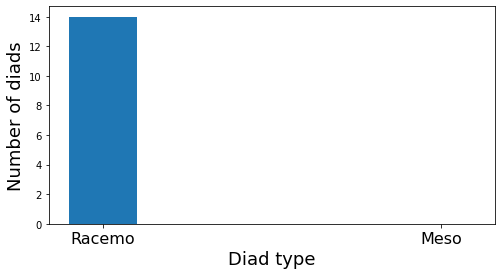

In [23]:
tacticity_stat = check_tacticity(polymer_nosim, [1, 2, 8, 10], len(sst.particles))

fig, ax = mplp.subplots(1, 1, figsize=(8, 4))
display_diad_distrib(tacticity_stat[1], ax);

Now let's do the same but with the forcefield optimization turned on, and see how many diads will be reconfigured from racemo- to meso- geometry.

In [24]:
polymer = random_walk_tacticity(new_sst, 15, forcefield=ff, tacticity=0.0, )

PySIMM: Molecule 1 inserted
11:46:13: 1/15 monomers added
syndiotactic insertion...
11:46:13: 2/15 monomers added
11:46:13: starting relax_002 LAMMPS simulation
11:46:13: relax_002 simulation using LAMMPS successful
11:46:13: starting LAMMPS simulation
11:46:14: simulation using LAMMPS successful
LAMMPS Energy = 1064.22
LAMMPS Energy/#ofAtoms = 14.989014084507042
syndiotactic insertion...
11:46:14: 3/15 monomers added
11:46:14: starting relax_003 LAMMPS simulation
11:46:15: relax_003 simulation using LAMMPS successful
11:46:15: starting LAMMPS simulation
11:46:15: simulation using LAMMPS successful
LAMMPS Energy = 1344.1263
LAMMPS Energy/#ofAtoms = 12.680436792452829
syndiotactic insertion...
11:46:15: 4/15 monomers added
11:46:15: starting relax_004 LAMMPS simulation
11:46:16: relax_004 simulation using LAMMPS successful
11:46:16: starting LAMMPS simulation
11:46:17: simulation using LAMMPS successful
LAMMPS Energy = 1837.9529
LAMMPS Energy/#ofAtoms = 13.03512695035461
syndiotactic in

In [25]:
display_system(polymer, 'some_chain.pdb')

NGLWidget()

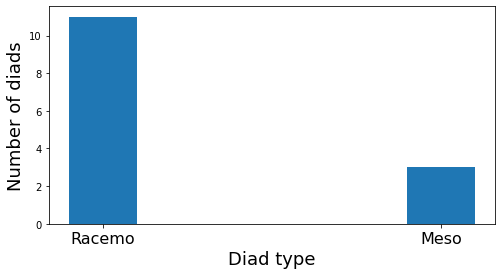

In [26]:
tacticity_stat = check_tacticity(polymer, [1, 2, 8, 10], len(sst.particles))

fig, ax = mplp.subplots(1, 1, figsize=(8, 4))
display_diad_distrib(tacticity_stat[1], ax);

 * The figure confirms that the optimization can change the initial distribution of monomer orientations. However, the chain obtained with `random_walk_tacticity()` has more recemo- than meso- diads (as the example was based on creating a syndiotactic polymer), as compared to the chain from the original `random_walk()` (10%-30%).


### A setup to construct a polymer chain with exact tacticity

In the previous section it was shown that in PySIMM one can easily construct a 'no simulation' polymer chain. The simple (but illustrative for tacticity explanations) chain is made by adding the monomers to each other *without* force field optimizations. 
The tacticity (ratio of meso-/racemo- diads) of that chain is easy to set to be exact, unlike the tacticity of a chain build with enabled forcefield optimizations. 
<br/><br/>
The robustness of the forcefield functional form allows one to run the simulations using the 'no simulation' chain as an initial structure. The long enough MD simulations with the fixed (via SHAKE) angle between the side radicals will result a relaxed polymer chain with exactly the same tacticity as it was constructed at the beginning.    
<br/>
*Please note, that depending on geometry of your repetitive unit the initial structure of chain of concatenated monomers might be defined more or less approximate. 
We recommend (if it is possible) to put linker atoms (tail and head atoms) into the anti-periplanar positions (see e.g. pCBMA repetitive unit in this tutorial).*
<br/> <br/>

Below is the small code listing that sets up (using PySIMM) the MD simulations starting with 'no simulation' configuration and result the relaxed polymer chain.


In [27]:
pmer_shake = polymer_nosim.copy()

sim = lmps.Simulation(pmer_shake, name='shake_relax', log='shake.log')

# This command adds a SHAKE fix to LAMMPS simulations which fixes an angle 
#  between two side chains of the pCBMA, and bonds that make that angle 
sim.add_custom('fix shck_fix all shake 0.001 40 0 b {} {} a {}'.format(
                    polymer.bond_types.get('CG2O2,CG301')[0].tag, 
                    polymer.bond_types.get('CG301,CG331')[0].tag, 
                    polymer.angle_types.get('CG331,CG301,CG2O2')[0].tag))

sim.add_md(ensemble='nve', limit=0.1, length=30000)
sim.run()
pmer_shake.unwrap()

display_system(pmer_shake)

11:47:32: starting shake_relax LAMMPS simulation
11:48:16: shake_relax simulation using LAMMPS successful


NGLWidget()

[True, False, False, False, False, False, False, False, False, False, False, False, False, False]


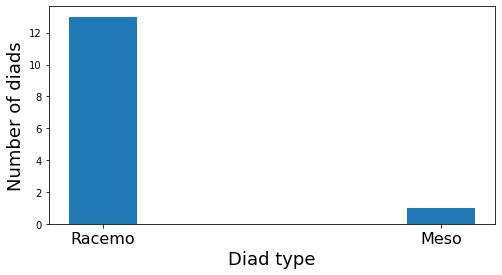

In [28]:
tacticity_stat = check_tacticity(pmer_shake, [1, 2, 8, 10], len(sst.particles))

fig, ax = mplp.subplots(1, 1, figsize=(8, 4))
display_diad_distrib(tacticity_stat[1], ax);
print(tacticity_stat[1])